# Data cleaning

In [3]:
! pip install pysurvival
# ! pip install scikit-survival

  Using cached pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl
  Using cached progressbar-2.5-py3-none-any.whl
  Using cached torch-1.9.0-cp36-cp36m-manylinux1_x86_64.whl (831.4 MB)
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sksurv.metrics import concordance_index_censored
# from sksurv.linear_model import CoxPHSurvivalAnalysis

# Part 1. Exploratory Analysis and Feature Engineering

### Basic descriptives

In [5]:
df=pd.read_csv('http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv')
print(df.shape)

(124494, 12)


In [6]:
# first few rows
df.head(2).T

,0,1
date,1/1/15,1/1/15
device,S1F01085,S1F0166B
failure,0,0
metric1,215630672,61370680
metric2,56,0
metric3,0,3
metric4,52,0
metric5,6,6
metric6,407438,403174
metric7,0,0


In [8]:
# except for the first two columns, all metrics are integers.
df.dtypes

date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object

### Hypotheses about the data:

* one reading every day, per device
* no more than one reading per day, per device
* most devices start on the same day (Jan 1st)
* there are no devices with two failure records (each device can only fail once)
* once a failure happens, device is removed from service
* some models never fail during the observation period (censoring)

### Data cleaning

In [9]:
# There is no obvious missing data in any variable.
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [10]:
# metrics 7 and 8 are identical. Drop one of them.
print('correlation:', df['metric7'].corr(df['metric8']))
print ('Are there any rows where 7!=8?', False in list(df['metric7']==df['metric8']))
df=df.drop('metric8', axis=1)
print(df.shape)

correlation: 1.0
Are there any rows where 7!=8? False
(124494, 11)


In [11]:
# There is only one instance of a duplicated device-date pair.
print('How many devices have 2 measurements in one day?', df[['device', 'date']].duplicated().sum())
# what is that row?
print(df[df[['device', 'date']].duplicated()==True][['device', 'date']])
df.loc[(df['device']=='S1F0R4Q8') & (df['date']=='2015-07-10')]

How many devices have 2 measurements in one day? 1
          device     date
101335  S1F0R4Q8  7/10/15


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9


In [12]:
# we should remove one of these duplicate rows.
df=df.drop(df.index[101335], axis=0)
df.reset_index(drop=True)
df.shape

(124493, 11)

In [13]:
# The dates are coded as strings. Replace this.
print(df['date'].dtype)
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)
df['date'].dtype

object


dtype('<M8[ns]')

In [14]:
# metric 1 appears to be an entirely random signal. remove it.
df['metric1'].describe()
df=df.drop('metric1', axis=1)

In [15]:
# what percentage of each is a zero? very high.
def lotsa_zeroes(col):
    numerator=len(df.loc[df[col]==0])
    denominator=len(df[col])
    print(col+':', round(numerator/denominator, 2))
for i in [2, 3,4,7]:
    lotsa_zeroes('metric'+str(i))

metric2: 0.95
metric3: 0.93
metric4: 0.92
metric7: 0.99


### Censoring
What is censoring? One of the challenges specific to survival analysis is that only some individuals will have experienced the event by the end of the study, and therefore survival times will be unknown for a subset of the study group. This phenomenon is called censoring

In [16]:
# How many unique devices are there?
df['device'].nunique()

1169

In [17]:
# Do all of them experience failure? Most do not.
df.groupby('device').max()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

In [18]:
# Do any fail multiple times? No.
df.groupby('device').sum()['failure'].value_counts()

0    1063
1     106
Name: failure, dtype: int64

For the most part, when a device fails it is removed. A few devices (5) continue after they're dead.

In [19]:
# confirm that there are no devices with two failure records (each device only fails once)
dffailed=df.loc[df['failure']==1]
assert dffailed['device'].nunique()==dffailed.shape[0]

In [20]:
# restrict to the date on which a device failed.
deaddevice=df[df['failure']==1][['device','date']]

In [21]:
# merge the deathdates back into the regular dataset.
deaddevice = deaddevice.rename(columns={'date': 'deathdate'})
df=pd.merge(df, deaddevice, on='device', how='outer')
df.shape

(124493, 11)

In [22]:
# confirm that, for failed devices, there are no entries later than the failure date.
devices=df.groupby('device').max().reset_index(drop=False)
dead_devices=devices.loc[devices['failure']==1]
dead_devices=dead_devices.rename(columns={'date': 'maxdate'})
dead_devices=dead_devices[['device', 'maxdate', 'deathdate']]
dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]

,device,maxdate,deathdate
101,S1F0GPFZ,2015-07-24,2015-07-12
504,S1F136J0,2015-05-06,2015-05-05
599,W1F0KCP2,2015-05-11,2015-05-09
625,W1F0M35B,2015-05-11,2015-05-09
819,W1F11ZG9,2015-08-17,2015-07-18


In [23]:
# For those 5 devices, remove any dates that occur after the failure.
zombies=dead_devices.loc[dead_devices['maxdate']!=dead_devices['deathdate']]['device']
print('Number of rows removed:', df.loc[(df['device'].isin(zombies)) & (df['date']>df['deathdate'])].shape[0])
print(df.shape[0])
df=df.loc[~((df['device'].isin(zombies)) & (df['date']>df['deathdate']))]
print(df.shape[0])
df=df.drop(['deathdate'], axis=1)

Number of rows removed: 47
124493
124446


## Feature engineering by device ID

In [24]:
# What's the first date in the series?
print(df['date'].min())
# Do all devices start on this same date? No.
bydevice=df.groupby('device')['date', 'failure'].min().reset_index(drop=False)
bydevice['date'].value_counts()

2015-01-01 00:00:00


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


2015-01-01    1163
2015-05-06       4
2015-01-27       1
2015-06-13       1
Name: date, dtype: int64

In [25]:
# creates new dataframe: one row for each device (reduces dimensions from 124K to 1163)
dfmin=df.groupby('device').min().reset_index(drop=False)
# same, but for max values
dfmax=df.groupby('device').max().reset_index(drop=False)

dfmin.head(2)

,device,date,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9
0,S1F01085,2015-01-01,0,56,0,52,6,407438,0,7
1,S1F013BB,2015-05-06,0,0,0,0,5,688952,0,0


Visualize a single device.

While the metrics are important, they are also not constant by device - they change over time. This calls for a time-series analysis. For the purpose of Cox regression, let's remove and focus only on device type (prefix).

In [26]:
# which metrics tend to change within a device? all of them.
dfcompare=pd.merge(dfmax, dfmin, on='device', how='left')
dfcompare['metric2_z']=dfcompare['metric2_x']-dfcompare['metric2_y']
dfcompare['metric3_z']=dfcompare['metric3_x']-dfcompare['metric3_y']
dfcompare['metric4_z']=dfcompare['metric4_x']-dfcompare['metric4_y']
dfcompare['metric5_z']=dfcompare['metric5_x']-dfcompare['metric5_y']
dfcompare['metric6_z']=dfcompare['metric6_x']-dfcompare['metric6_y']
dfcompare['metric7_z']=dfcompare['metric7_x']-dfcompare['metric7_y']
dfcompare['metric9_z']=dfcompare['metric9_x']-dfcompare['metric9_y']
for var in ['metric2_z','metric3_z','metric4_z','metric5_z','metric6_z','metric7_z','metric9_z']:
    print(str(var), dfcompare[var].mean())
# this suggests that metrics change, and are an indicator of health.

metric2_z 633.0675791274593
metric3_z 2.223267750213858
metric4_z 6.098374679213003
metric5_z 0.4679213002566296
metric6_z 31298.350727117195
metric7_z 4.076988879384089
metric9_z 0.1787852865697177


In [27]:
# just focus on the date for now. Create a column indicating the minimum date, for each device.
dfmin=dfmin[['device', 'date']]
dfmin.rename(columns={'date':'mindate'},inplace=True)
print(dfmin.shape)
dfmin.head()

(1169, 2)


,device,mindate
0,S1F01085,2015-01-01
1,S1F013BB,2015-05-06
2,S1F0166B,2015-01-01
3,S1F01E6Y,2015-01-01
4,S1F01JE0,2015-01-01


In [28]:
# We can group devices into 7 categories based on their device ID code
dfmin['prefix']=dfmin['device'].apply(lambda row: row[:4])
dfmin['prefix'].value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: prefix, dtype: int64

In [29]:
# merge the groupby-dataset back into primary the dataset
print(df.shape)
df=pd.merge(df, dfmin, on='device', how='left')

(124446, 10)


In [30]:
# create a column to measure elapsed time.
df['timelapse']=(df['date']-df['mindate']).dt.days
df['timelapse'].value_counts()

0      1169
1      1168
2      1168
3      1167
4      1166
       ... 
303      31
302      31
301      31
305      31
299      31
Name: timelapse, Length: 304, dtype: int64

In [31]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(df['prefix'])
df=pd.concat([df, ohe],axis=1)
df.drop(['prefix'],axis=1)
df.head()

,date,device,failure,metric2,metric3,metric4,metric5,metric6,metric7,metric9,mindate,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
0,2015-01-01,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,0,1,0,0,0,0,0,0
1,2015-01-02,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,1,1,0,0,0,0,0,0
2,2015-01-03,S1F01085,0,56,0,52,6,407438,0,7,2015-01-01,S1F0,2,1,0,0,0,0,0,0
3,2015-01-04,S1F01085,0,56,0,52,6,407439,0,7,2015-01-01,S1F0,3,1,0,0,0,0,0,0
4,2015-01-05,S1F01085,0,56,0,52,6,408114,0,7,2015-01-01,S1F0,4,1,0,0,0,0,0,0


In [32]:
# What's the longest-lived device that failed?
print(df['timelapse'].max())
df.loc[(df['timelapse']>=280) & (df['failure']==1)]['device'].unique()
T0B1=df.loc[df['device']=='W1F0T0B1']

305


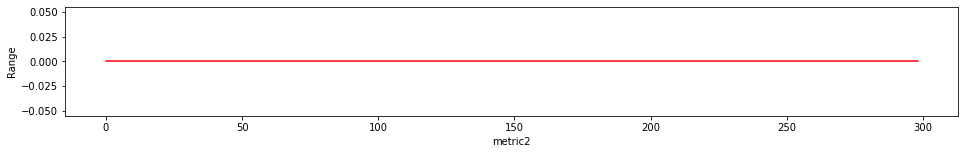

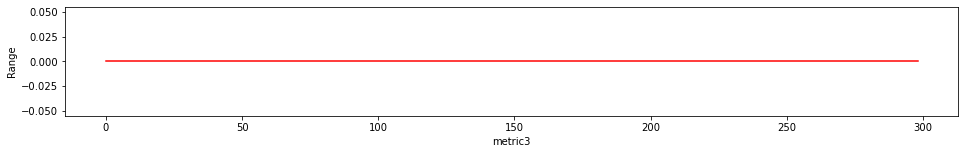

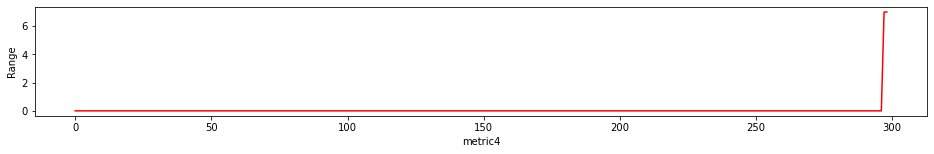

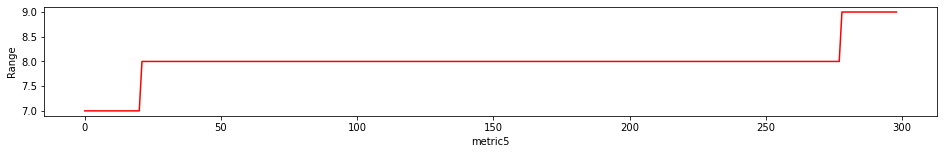

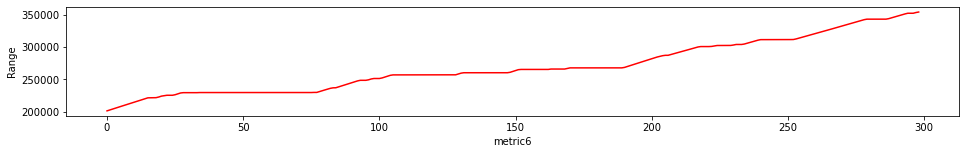

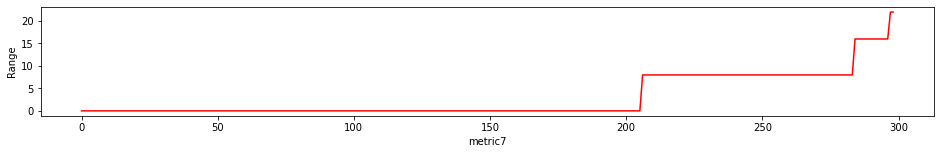

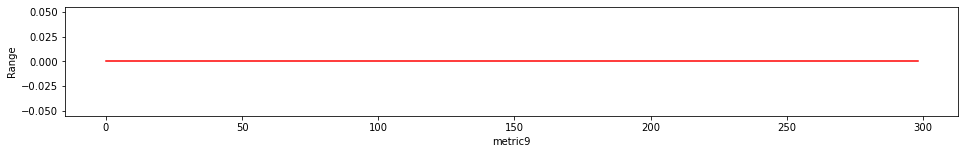

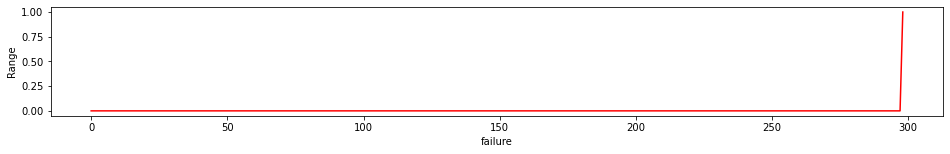

In [33]:
# display the metrics for one device
metrics=['metric2','metric3','metric4','metric5','metric6','metric7','metric9','failure']
for num in range(len(metrics)):
    plt.figure(figsize=(16,2))
    plt.plot(T0B1['timelapse'], T0B1[metrics[num]], color = 'r')
    plt.xlabel(metrics[num])
    plt.ylabel("Range")
    plt.show()

# Part 2. Modeling

## Cox regression analysis

The Cox proportional hazards model (1972) is widely used in multivariate survival statistics due to a relatively easy implementation and informative interpretation. It describes relationships between survival distribution and covariates. The Cox model makes an estimation of log-risk function λ(t|x) as a linear combination of its static covariates and baseline hazard.

In [29]:
# because metrics tend to vary over time, they're not fixed variables by device.
# device prefix does not vary, and thus serves as an independent variable.
coxdf = df[['device', 'failure', 'prefix', 'timelapse']]
coxdf = coxdf.groupby('device').max()
print(coxdf.shape)
coxdf.tail()

(1169, 3)


,failure,prefix,timelapse
device,,,
Z1F1VMZB,0,Z1F1,291
Z1F1VQFY,1,Z1F1,180
Z1F26YZB,0,Z1F2,83
Z1F282ZV,0,Z1F2,83
Z1F2PBHX,0,Z1F2,95


In [30]:
# one-hot encoding of device prefix
ohe=pd.get_dummies(coxdf['prefix'])
coxdf=pd.concat([coxdf, ohe],axis=1)
coxdf.head()

,failure,prefix,timelapse,S1F0,S1F1,W1F0,W1F1,Z1F0,Z1F1,Z1F2
device,,,,,,,,,,
S1F01085,0,S1F0,5,1,0,0,0,0,0,0
S1F013BB,0,S1F0,5,1,0,0,0,0,0,0
S1F0166B,0,S1F0,5,1,0,0,0,0,0,0
S1F01E6Y,0,S1F0,47,1,0,0,0,0,0,0
S1F01JE0,0,S1F0,5,1,0,0,0,0,0,0


Survival models in scikit-survival follow the same rules as estimators in scikit-learn, i.e., they have a fit method, which expects a data matrix and a structured array of survival times and binary event indicators.

In [31]:
# We drop one category for comparison purposes (intercept)
X=coxdf.drop(['prefix','failure','timelapse','S1F0'],axis=1)
X.columns

Index(['S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2'], dtype='object')

In [32]:
# Convert time & failure into a structured array of booleans
coxdf['failure']=coxdf['failure'].astype('bool')
y=coxdf[['failure','timelapse']].to_records(index=False)
y[:5]

rec.array([(False,  5), (False,  5), (False,  5), (False, 47),
           (False,  5)],
          dtype=[('failure', '?'), ('timelapse', '<i8')])

In [33]:
# Split our data with a test size of 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
# Instantiate and fit the estimator
estimator = CoxPHSurvivalAnalysis()
estimator.fit(X_train, y_train)

CoxPHSurvivalAnalysis()

In survival analysis, the hazard ratio (HR) is the ratio of the hazard rates corresponding to the conditions described by two levels of an explanatory variable. Each coefficient is a hazard ratio for that specific variable. 

- A positive sign increases the baseline hazard λ0(t) and denotes that this covariate affects a higher risk of experiencing the event of interest. In contrary, a negative sign means that the risk of the event is lower.
- For example, in a drug study, the treated population may die at twice the rate per unit time of the control population. The hazard ratio would be 2, indicating higher hazard of death from the treatment.

In [35]:
# extract coefficients
pd.Series(estimator.coef_, index=X_train.columns)

S1F1    -1.084052
W1F0     0.398483
W1F1    -0.164566
Z1F0    -0.212950
Z1F1     0.412637
Z1F2   -14.078557
dtype: float64

the `predict_survival_function` method returns a sequence of step functions, which we can plot. This shows the probability of a device not failing, for a given point in time (measured in days since device activation).

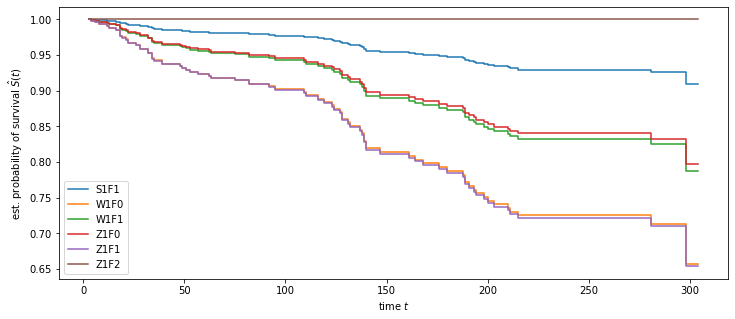

In [36]:
# create 7 new cases
x_new = pd.DataFrame.from_dict({
    1: [1,0,0,0,0,0],
    2: [0,1,0,0,0,0],
    3: [0,0,1,0,0,0],
    4: [0,0,0,1,0,0],
    5: [0,0,0,0,1,0],
    6: [0,0,0,0,0,1]
},
     columns=X_train.columns, orient='index')

# list the device categories
device_types=list(X_train.columns)
# display as curves
pred_surv = estimator.predict_survival_function(x_new)
time_points = np.arange(3, 305)
plt.figure(figsize=(12,5))
for i, surv_func in enumerate(pred_surv):
    plt.step(time_points, surv_func(time_points), where="post",
             label=device_types[i])
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best");

### Evaluation of Cox Regression

The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic).  It is a measure of rank correlation between predicted risk scores f and observed time points y. Metrics like root mean squared error or correlation are unsuitable due to censoring.  The interpretation is identical to the traditional area under the ROC curve metric for binary classification: 
- a value of 0.5 denotes a random model, 
- a value of 1.0 denotes a perfect model, 
- a value of 0.0 denotes a perfectly wrong model.

In [37]:
# Measuring the Performance of the Survival Model
print(estimator.score(X_test,y_test))

0.5950986135520406


Our model's c-index indicates that the model performs better than random chance, but is far from perfect. This is likely because we removed all of the attribute variables (metrics 2-9) from the analysis, which could have served as predictors. What this tells us is that lifespan, by itself, is not a strong predictor of when a device will fail (i.e., simply being old by itself is not necessarily a predictor of failure).  

A different approach (time series analysis) can take into account the device metrics which likely indicate upcoming failure.

## Linear Modeling

In [34]:
# make a list of features
features = ['metric2', 'metric3', 'metric4', 'metric5', 'metric6', 'metric7',
            'metric9','S1F0', 'S1F1', 'W1F0', 'W1F1', 'Z1F0', 'Z1F1', 'Z1F2']
features = ['metric6'] # let's try with a single predictor, and later we'll expand the model.

In [35]:
# randomly select device ID numbers for train-test split
import random
device_ids=list(df['device'].unique())
test_size=int(len(device_ids)*.4)
print(test_size)
test_list = random.sample(device_ids, test_size)
print(test_list[:5])

467
['W1F0G9T7', 'W1F0X6TM', 'W1F1BW8W', 'Z1F0FSBY', 'S1F0QWZP']


In [36]:
# train-test split
data_test = df[df['device'].isin(test_list)]
data_train = df[~df['device'].isin(test_list)]
print(len(df))
print(len(data_train))
print(len(data_test))
assert len(data_train)+len(data_test)==len(df)

124446
76748
47698


In [37]:
# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train['timelapse'], data_test['timelapse']
E_train, E_test = data_train['failure'], data_test['failure']

The [Multi-Task Logistic Regression](https://square.github.io/pysurvival/tutorials/maintenance.html) (MTLR) model is an alternative to the Cox’s proportional hazard model. It can be seen as a series of logistic regression models built on different time intervals so as to estimate the probability that the event of interest happened within each interval.

In [38]:
# Let's now fit a Linear MTLR model to the training set. 
from pysurvival.models.multi_task import LinearMultiTaskModel

# Initializing the MTLR with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

# Fitting the model
linear_mtlr.fit(X_train, T_train, E_train, 
                num_epochs = 1000,
                init_method = 'orthogonal', 
                optimizer ='rmsprop',
                lr = 1e-3, 
                l2_reg = 3,  
                l2_smooth = 3, )

% Completion: 100%|***********************************************|Loss: 921.72


LinearMultiTaskModel

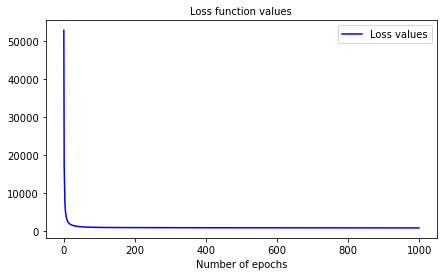

In [39]:
from pysurvival.utils.display import display_loss_values
display_loss_values(linear_mtlr, figure_size=(7, 4))

The C-index represents the global assessment of the model discrimination power: this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but if it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [40]:
from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(linear_mtlr, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) 

C-index: 0.70


## Neural Multi-Task Logistic Regression model (N-MTLR) 

In [44]:
# Instantiate
from pysurvival.models.multi_task import NeuralMultiTaskModel
structure = [ {'activation': 'ReLU', 'num_units': 128}, ]
neural_mtlm = NeuralMultiTaskModel(structure, bins=100, auto_scaler=True)
# Fitting the model
neural_mtlm.fit(X_train, T_train, E_train, 
                init_method = 'glorot_uniform', 
                optimizer ='adam',
                lr = 1e-4, 
                num_epochs = 1000, 
                dropout = 0.2, 
                l2_reg=1e-2,
                l2_smooth=1e-2, 
                batch_normalization=False, 
                bn_and_dropout=False,
                verbose=True, 
                extra_pct_time = 0.1, 
                is_min_time_zero=True)

% Completion: 100%|***********************************************|Loss: 917.86


NeuralMultiTaskModel( Layer(1): activation = ReLU, units = 128 )

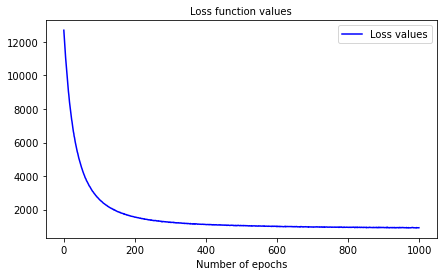

In [48]:
display_loss_values(neural_mtlm, figure_size=(7, 4))

In [47]:
c_index = concordance_index(neural_mtlm, X_test, T_test, E_test)
print('C-index: {:.2f}'.format(c_index)) 

C-index: 0.71


Conclusion: The model included a single independent variable (Metric 6) which had the greatest variance over time. We left out a number of other predictors (the other metrics, and "prefix") because these had little or no variance over time. A future iteration of the model would include these as independent variables. This would likely improve the c-value above .71.